# **EDA for word_count variable**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st

# ploting
import matplotlib.pyplot as plt
# model initial:
import statsmodels.api as sm

In [2]:
#Set import folder
input_folder = "kaggle/input/linking-writing-processes-to-writing-quality/"

In [3]:
# Load train logs
train_logs = pd.read_csv(input_folder + "train_logs.csv",delimiter = ",",header = 0)
# Set the id and event id as index:
train_logs_indexed = train_logs.set_index(['id', 'event_id'])
# Load train scores
train_scores = pd.read_csv(input_folder +"train_scores.csv", delimiter = ",", header = 0)
scores = pd.Series(data = train_scores['score'].values, index = train_scores['id'].values, name = 'score')

In [4]:
train_logs.head(2)

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0


In [5]:
train_logs.shape

(8405898, 11)

In [6]:
# Check the distribution of the label dataset:
sum = 0
for i in (np.arange(0.5, 6.5, 0.5)):
    print("score = {}: length = {}".format(i,scores[scores == i].shape[0]))
    #print("score = {}: length = {}".format(i,scores[scores == i].shape[0]))
    sum += scores[scores == i].shape[0]
print("sum: {}".format(sum))

score = 0.5: length = 5
score = 1.0: length = 35
score = 1.5: length = 69
score = 2.0: length = 92
score = 2.5: length = 201
score = 3.0: length = 336
score = 3.5: length = 486
score = 4.0: length = 501
score = 4.5: length = 402
score = 5.0: length = 179
score = 5.5: length = 128
score = 6.0: length = 37
sum: 2471


In [7]:
score_05 = scores[scores == 0.5].index.values
score_60 = scores[scores == 6.0].index.values

In [8]:
score_05.shape

(5,)

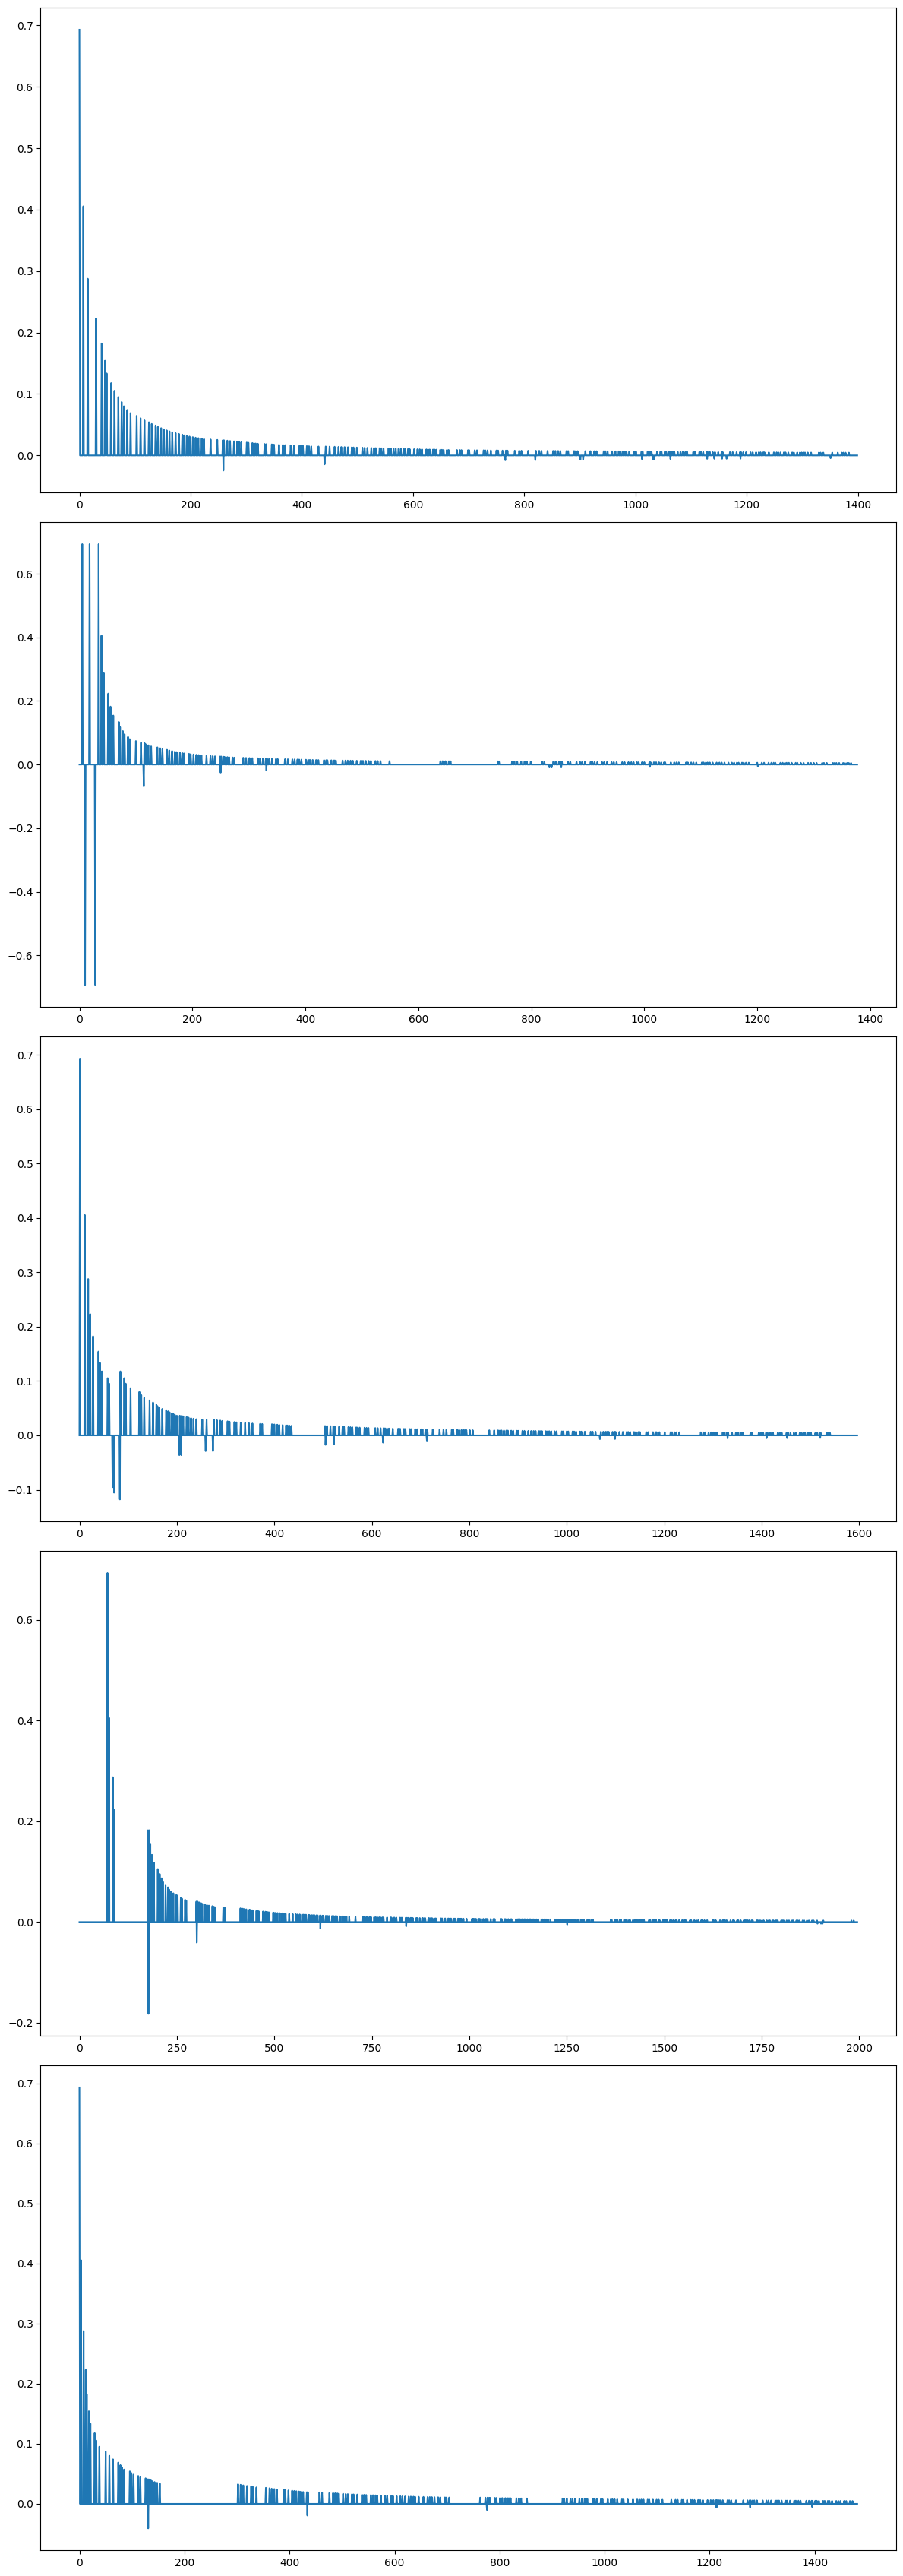

In [9]:
fig, ax = plt.subplots(nrows = score_05.shape[0], figsize = (12, 34))
for i in range(score_05.shape[0]):
    wc = train_logs_indexed.loc[score_05[i]].word_count.agg(lambda x: np.diff(np.log(x+1))) 
    ax[i].plot(np.arange(0,wc.shape[0]), wc)
fig.tight_layout()
plt.show()

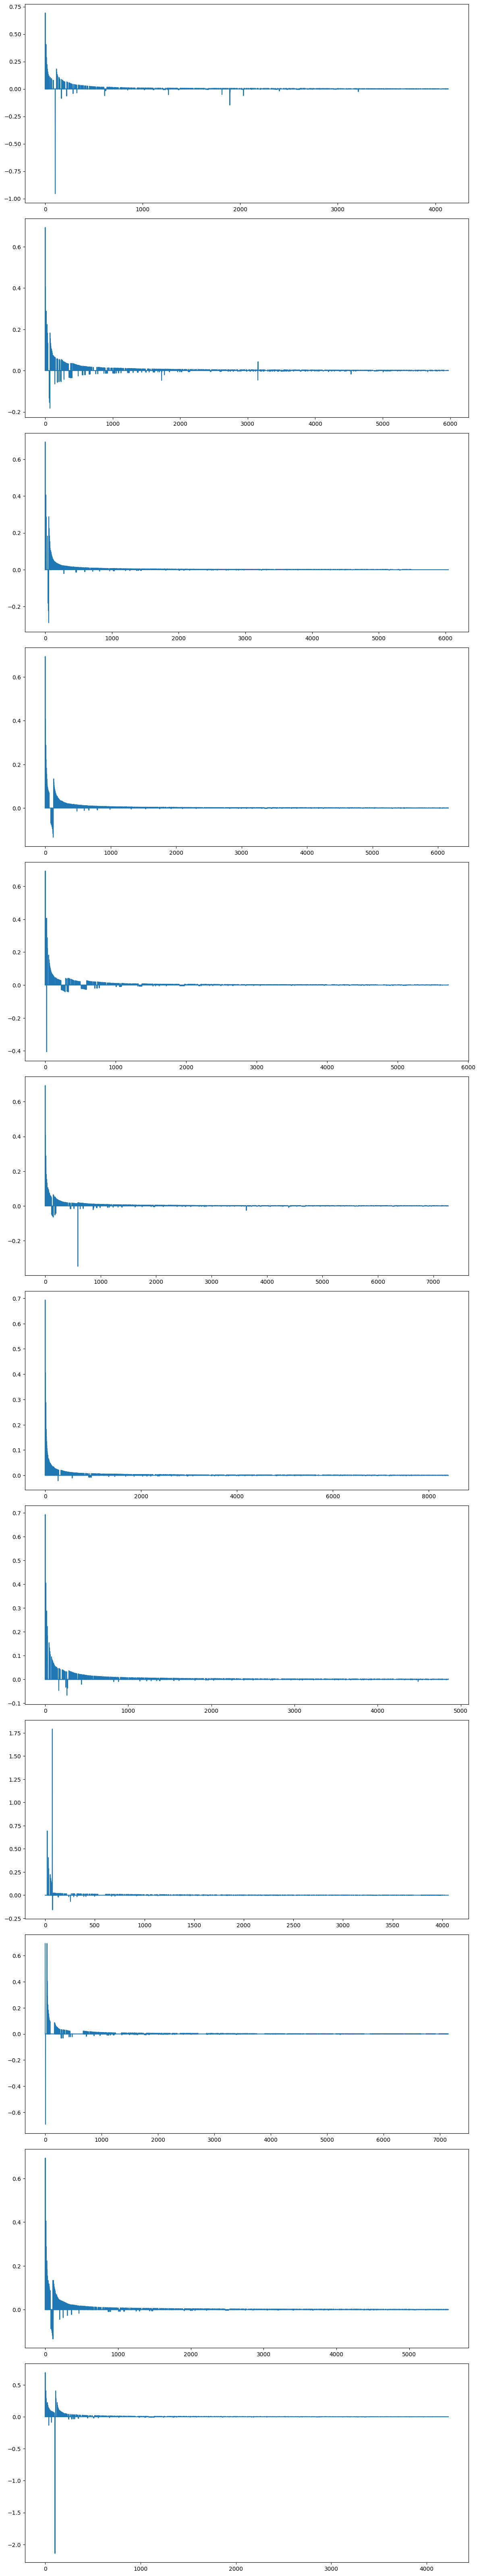

In [10]:
graph_n = 12
fig, ax = plt.subplots(nrows = graph_n, figsize = (12, 64))
for i in range(graph_n):
    wc = train_logs_indexed.loc[score_60[i]].word_count.agg(lambda x: np.diff(np.log(x+1))) 
    ax[i].plot(np.arange(0,wc.shape[0]), wc)
fig.tight_layout()
plt.show()

In [11]:
# word_count feature engineering
# Based on the graph above, we can count the number of zero changes and get the mean:
# wc_zero_change will return the count of all non-zero steps taken by the person
def wc_non_zero_change(x):
    n1 = np.diff(np.log(x+1))
    n2 = np.count_nonzero(n1)
    return n2
def wc_change_stat(x):
    n1 = np.diff(np.log(x+1))
    last_cutoff = n1.shape[0]-200
    n2 = np.mean(n1)
    return n2
    
wc = train_logs.groupby('id')['word_count'].aggregate([wc_non_zero_change,
                                                       lambda x: np.log(len(x)), 
                                                       lambda x: np.log(np.max(x)),
                                                       wc_change_stat])
wc.columns = ["wc_changing_nsteps", "wc_step_count", "wc_max", "wc_change_stat"]
wc["wc_interaction"] = np.log(wc.wc_changing_nsteps * wc.wc_max)
wc.head(3)

,wc_changing_nsteps,wc_step_count,wc_max,wc_change_stat,wc_interaction
id,,,,,
001519c8,438,7.846590,5.545177,0.002169,7.795148
0022f953,418,7.805475,5.777652,0.002353,7.789479
0042269b,619,8.327484,6.001415,0.001452,8.220101


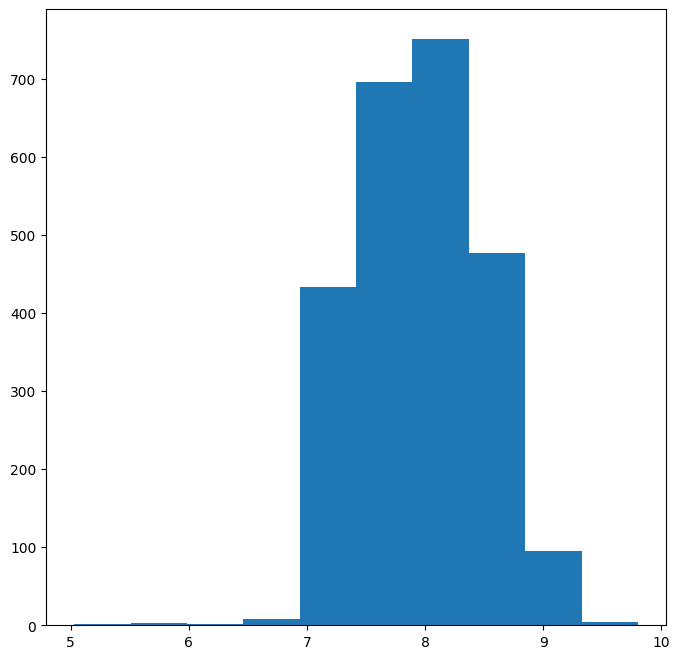

In [12]:
fi = plt.figure(figsize = (8,8)) 
plt.hist(wc.wc_interaction, figure = fi)
plt.show()

In [13]:
z = pd.merge(wc, scores, left_index = True, right_index = True)
z.corr()

,wc_changing_nsteps,wc_step_count,wc_max,wc_change_stat,wc_interaction,score
wc_changing_nsteps,1.000000,0.902469,0.864394,-0.787653,0.956791,0.613450
wc_step_count,0.902469,1.000000,0.836508,-0.950550,0.936501,0.646826
wc_max,0.864394,0.836508,1.000000,-0.762695,0.921823,0.691226
wc_change_stat,-0.787653,-0.950550,-0.762695,1.000000,-0.879595,-0.612563
wc_interaction,0.956791,0.936501,0.921823,-0.879595,1.000000,0.680254
score,0.613450,0.646826,0.691226,-0.612563,0.680254,1.000000


In [14]:
# cursor_position_change_var is not significant
#X = z[['wc_interaction', 'wc_change_stat']] 
X = z.drop(['score'], axis = 1)
X = sm.add_constant(X)
Y = z.score

sm.OLS(Y,X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     507.7
Date:                Mon, 08 Jan 2024   Prob (F-statistic):               0.00
Time:                        15:47:35   Log-Likelihood:                -2691.9
No. Observations:                2471   AIC:                             5396.
Df Residuals:                    2465   BIC:                             5431.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -18.8900      2.098     -9.003      0.000     -23.004     -14.776
wc_changing_nsteps    -0.0022      0.000     -7.554      0.000      -0.003      -0.002
wc_step_count          0.9342      0.181      5.160      0.000       0.579       1.289
wc_max                 0.9169      0.101      9.069      0.000       0.719       1.115
wc_change_stat       260.5362     80.222      3.248      0.001     103.227     417.846
wc_interaction         1.3004      0.190      6.834      0.000       0.927       1.674
==============================================================================
Omnibus:                      160.468   Durbin-Watson:                   2.076
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              229.389
Skew:                          -0.552   Prob(JB):                     1.54e-50
Kurtosis:                       4.005   Cond. No.                     3.29e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.29e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""